# Preprocessing Pipeline

### Imports

In [1]:
import os.path
import pyxdf
import pandas as pd
import mne
from os import path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tkinter import Tk
from tkinter.filedialog import askdirectory
import glob, os
from autoreject import get_rejection_threshold
import promptlib
import autoreject  
import math


### Constants

In [2]:
TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
EVENTS = {
    'Baseline' : None,
    'MI' : 'MI trial marker',
    'PO' : 'Unity.Marker.TargetID'
}
EPOCH_VAR = {
    'TIME_OFFSET' : TIME_OFFSET,
    'DUR' : DUR,
    'EVENTS' : EVENTS
}
MONTAGE = 'DATA/montage_perfect.csv'
ICA_RECAP = 'DATA/ica_recap.csv'

In [4]:
montage_label = pd.read_csv(MONTAGE)
channel_label = montage_label['ch_name'].tolist()
montage_label.head()


ch_name      x      y       z
0     FP1 -0.309  0.951  0.0000
1     FPZ  0.000  1.000 -0.0001
2     FP2  0.309  0.951  0.0000
3      F7 -0.809  0.588  0.0000
4      F3 -0.534  0.659  0.5300

### Functions

In [5]:
def select_stream(stream_data, selection='type',desired_type='EEG'):
    
    for stream in stream_data:
        stream_type = stream['info'][selection][0]
        
        if stream_type == desired_type and len(stream['time_series'])>0:
            return stream
        else:
            continue

def show_epoch(epochs,n_epochs=10):
    if epochs != None:
        print(epochs)
        print(epochs.events)
        epochs.plot(n_epochs=n_epochs,events=epochs.events, event_id=epochs.event_id)


        
def select_eegs(xdf_files):
    
    eeg_files = []

    for file in xdf_files:
        print('Processing {}'.format(file))
        data,header = pyxdf.load_xdf(file);
        eeg_file = select_stream(data);
        eeg_file['file'] = os.path.basename(os.path.normpath(file));
        eeg_files.append(eeg_file);
    
    return eeg_files

def raw_processing(raw,filtering,bad_chs,fmin=0.1,fmax=40):
    signal = raw.copy()
    
    if isinstance(bad_chs,str):
        bad_chs = bad_chs.split(',') + ['M1','M2','EOG']
    else:
        bad_chs = ['M1','M2','EOG']
    
    if bad_chs.count('CPZ') > 0:
        bad_chs.remove('CPZ')
        
    signal.info['bads'].extend(bad_chs)

    if "BP" in filtering:
        signal = signal.filter(fmin,fmax)

    if filtering == 'rawBPCAR':
        signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
    
    return signal
    
def to_mne(data_path, filtering, NB_CHANNELS = 64):
    stream,header = pyxdf.load_xdf(data_path)
    stream_eeg = select_stream(stream)

    if stream_eeg is None:
        print("No EEG for " + data_path)
        signal = None;
        eventss = None;
        event_idss = None;
        return signal, eventss, event_idss
    
    ch_names = []
    channels = stream_eeg['info']['desc'][0]['channels'][0]['channel']
    file = os.path.basename(os.path.normpath(data_path))

    for channel in channels:
        current_label = channel['label'][0]
        if (current_label != 'AUX3') & (current_label != 'TRIGGER'):
            ch_names.append(channel['label'][0])
        else:
            continue

    data = stream_eeg["time_series"].copy().T;  # data.shape = (nb_channels, nb_samples)
    data = data[0:64,:] # We do not keep data for AUX3 and TRIGGER
    data *= 1e-6  # convert from uV to V (mne uses V)
    #assert len(data) == NB_CHANNELS      
    sfreq = float(stream_eeg["info"]["nominal_srate"][0])
    ch_types = ['eeg'] * 64;
    info = mne.create_info(ch_names, sfreq, ch_types);
    # info = mne.create_info(NB_CHANNEfLS, sfreq)
    raw = mne.io.RawArray(data, info);

    ### Filtering and CAR
    subject = file.split('_')[0];
    bad_chs = get_bad_chs(subject);
    
    signal = raw_processing(raw,filtering,bad_chs);
    

    ### Epoch management
    
    
    event_keys = list(EVENTS.keys());
    event_type = [key for key in event_keys if key in file][0];
    print('Subject: {}, EVENT: {}'.format(subject,event_type))
    if event_type == 'PO':
        
        event_id = {
            'Left':1,
            'Right':2,
            'Third':3
        }
        stream_event = select_stream(stream,'name',EVENTS[event_type]);
        if stream_event is None:
            eventss = None;
            event_idss = None;
        else:
            target_nb = np.array(stream_event['time_series']).squeeze();  # array with target IDs
            t_origin = stream_eeg['time_stamps'][0];
            t_stamps = stream_event['time_stamps'] - t_origin;
            annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
            raw_annotated = signal.copy().set_annotations(annots);
            eventss, event_idss = mne.events_from_annotations(raw_annotated);
            epochs = mne.Epochs(raw_annotated, eventss, event_id, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=400e-6), proj=False, reject_by_annotation=None);
        '''
        reject = get_rejection_threshold(epochs)
        epochs = mne.Epochs(raw_annotated, eventss, event_id, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=reject), proj=False)
        '''
        
    elif event_type == 'MI':
        '''
        t_origin = stream_eeg['time_stamps'][0]
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        time_stamps = stream_event['time_stamps'] - t_origin  # signal begins at 0s
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        TIME_OFFSET = -1
        annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)
        rawannot = rawBPCAR.copy().set_annotations(annots)


        #### Create events from annotations

        events, event_id = mne.events_from_annotations(rawannot)
        # print(event_id)
        # print(events)


        #### Create mne.Epochs with events and event_ID
        # also define the event window 

        epochs = mne.Epochs(rawBPCAR, events, event_id, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6))
        '''
        
        stream_event = select_stream(stream,'name',EVENTS[event_type]);
        if stream_event is None:
            eventss = None;
            event_idss = None;
        else:
            target_nb = np.array(stream_event['time_series']).squeeze();  # array with target IDs
            t_origin = stream_eeg['time_stamps'][0];

            n_trial = int(len(stream_event['time_stamps'])/30);
            t_stamps = np.empty(0)
            for j in range(n_trial):
                ts = [stream_event['time_stamps'][30*(j-1)] - t_origin +2 + 9* i for i in range(30)];
                t_stamps = np.concatenate((t_stamps, ts));
            '''
            ts_1 = [stream_event['time_stamps'][0] - t_origin +2 + 9* i for i in range(30)];
            ts_2 = [stream_event['time_stamps'][30] - t_origin +2 + 9* i for i in range(30)];
            t_stamps = np.concatenate((ts_1, ts_2));
            '''
            t_onset = t_stamps;
            annots = mne.Annotations(onset=t_onset, duration = 9, description=target_nb);  
            raw_annotated = signal.copy().set_annotations(annots);
            #reject = get_rejection_threshold(signal)
            eventss, event_idss = mne.events_from_annotations(raw_annotated);
            epochs = mne.Epochs(raw_annotated, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=400e-6), proj=False, reject_by_annotation=None)
        '''
        
        epochs = mne.Epochs(raw_annotated, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=reject), proj=False)
        '''
    else:
        eventss = None;
        event_idss = None;
        #epochs = None


    return signal, eventss, event_idss

def get_epochs(EEG_dict,EVENTS_dict):
    ### Epoch management
    
    conditions = list(EEG_dict.keys())
    
    for condition in conditions:
 
        signal = EEG_dict[condition]['signal']
        eventss = EVENTS_dict[condition]['events']
        event_idss = EVENTS_dict[condition]['events_ids']

        if "Baseline" in condition:
            epochs = None
        else:
            epochs = mne.Epochs(signal, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=None, proj=False, reject_by_annotation=None)
            reject = get_rejection_threshold(epochs)
            reject_criteria = dict(eeg=reject)
            epochs = mne.Epochs(signal, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=reject, proj=False, reject_by_annotation=None)
        
        EEG_dict[condition]['epochs'] = epochs

    
    return EEG_dict

def read_file(path,filtering='rawBPCAR'):
    
    initial_directory = os.getcwd()
    xdf_files = []

    for file in glob.glob(path+"\*.xdf"):
        if 'MIpre' in file or 'MIpost' in file:
            xdf_files.append(file)

    EEG_dict = {}
    EVENTS_dict = {}
    for file in xdf_files:
        mne_data,events,events_idss = to_mne(file,filtering)

        if mne_data is None:
            continue
        else:
            file_name = os.path.basename(file).split('.')[0]
            EEG_dict[file_name] = {}
            EEG_dict[file_name]['signal'] = mne_data
            #EEG_dict[file_name]['epochs'] = epochs
            EVENTS_dict[file_name] = {}
            EVENTS_dict[file_name]['events'] = events
            EVENTS_dict[file_name]['events_ids'] = events_idss
    
    return EEG_dict,EVENTS_dict

def save_fif(EEG_dict):
    EEG_keys = list(EEG_dict.keys())
    subject_ID = EEG_keys[0].split('-')[1].split('_')[0]
    
    if int(subject_ID[1:3]) < 11:
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
    
    path = "Data/" + grp + "/" + subject_ID + "/FIF/" 
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
    for condition in EEG_keys:
        EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)
        
        if EEG_dict[condition]['epochs'] != None:
            EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)
    
def get_montage(csv_file, scale_factor=0.095):
    """
    Get the montage of the EEG data
    :param csv_file: csv file with the montage
    :param scale_factor: scale factor for the montage
    :return: montage
    """
    df_montage = pd.read_csv(csv_file)
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(df_montage['ch_name'], df_montage[['x', 'y', 'z']].values*scale_factor)), coord_frame='head')
    # montage.plot();
    return montage

def interpolate_bad_channels(raw, montage, bad_channels=[]):
    """
    Interpolate bad channels
    :param raw: raw data
    :param bad_channels: list of bad channels
    :return: raw data with interpolated bad channels
    """
    if bad_channels != []:
        raw.info['bads'].extend(bad_channels)
        raw.set_montage(montage)
        print("Interpolating channels: ", raw.info['bads'], "exclude M1, M2, Trigger")
        raw_interp = raw.copy().interpolate_bads(exclude=['M1', 'M2', 'Trigger'])
        raw_interp.plot(scalings=0.00013); 
        # print list of interpolated channels
        return raw_interp
    else:
        print("No bad channels to interpolate")
        return raw

def ica_analysis(signal,n_components=20,random_seed=0):
    ica = mne.preprocessing.ICA(n_components=20,random_state=0)
    signal.set_montage(get_montage(MONTAGE),on_missing='warn')
    ica.fit(signal.copy().filter(0.1,40))
    ica.plot_components()
    ica.plot_sources(signal.copy().filter(0.1,40))
    return ica

def get_bad_chs(subject):
    ch_recap = pd.read_csv("Data\ch_recap_ica.csv")
    bad_chs = ch_recap[ch_recap['group'] == subject]['interpolated_channels'].squeeze()
    if not isinstance(bad_chs,str):
        bad_chs = [];
    
    return bad_chs

def get_ica(EEG_dict):
    conditions = list(EEG_dict.keys())
    ICA_dict ={}
    for condition in conditions:
        ica = mne.preprocessing.ICA(n_components=25,random_state=0);
        signal = EEG_dict[condition]['signal'].copy();
        signal.set_montage(get_montage(MONTAGE),on_missing='warn');
        ica.fit(signal.copy());
        ICA_dict[condition] = ica.copy();

    return ICA_dict

def apply_ica(EEG_dict,ICA_dict):
    ica_recap = pd.read_csv(ICA_RECAP)
    EEG_keys = list(EEG_dict.copy().keys())

    EEG_dict_2 = EEG_dict.copy()
    EEG_dict_corrected = EEG_dict.copy()
    for condition in EEG_keys:
        bad_comp = ica_recap[ica_recap['condition'] == condition]['bad_components'].copy().squeeze()
        if bad_comp != "None":
            bad_comp = [int(x) for x in bad_comp.split(',')];
            ica = ICA_dict[condition].copy()
            signal = EEG_dict[condition]['signal'].copy()
            eeg_corrected = ica.apply(signal.copy(),exclude=bad_comp)
            EEG_dict_corrected[condition]['signal'] = eeg_corrected.copy()

    return EEG_dict_2,EEG_dict_corrected.copy()
    
def save_ica_imgs(ICA_dict,EEG_dict):
    conditions = list(ICA_dict.keys())
    subject_ID = conditions[0].split('-')[1].split('_')[0]
    
    if int(subject_ID[1:3]) < 11:
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
        
    path = "Data/" + grp + "/" + subject_ID + "/" + "ICA_data/"
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
        
    for condition in conditions:
        print('Subject ' + subject_ID + ': ' + condition)
        ica_comp = ICA_dict[condition].plot_components()
        ica_sources = ICA_dict[condition].plot_sources(EEG_dict[condition]['signal'].copy())
        ICA_dict[condition].save(path+condition+"_ica",overwrite=True)
        ica_comp[0].savefig(path+condition+'_ica_comp.png')
        ica_comp[1].savefig(path+condition+'_ica_comp_2.png')
        ica_sources.savefig(path+condition+'_ica_sources.png')
        
def process_all(folder_idxs,filtering="rawBP"):
    for idx in folder_idxs:
        if idx < 11:
            path = 'Data/Group_Realistic_Arm/S'
            if idx < 10:
                path = path+'0'+str(idx)
            else:
                path = path+str(idx)
        else:
            path = 'Data/Group_Realistic_Arm_Tactile/S'+str(idx)
        print("Processing: " + path)
     
        EEG_dict,EVENTS_dict = read_file(path,filtering);
        ICA_dict = get_ica(EEG_dict.copy())
        save_ica_imgs(ICA_dict,EEG_dict)

def ica_correction(folder_idxs):
    for idx in folder_idxs:
        if idx < 11:
            path = 'Data/Group_Realistic_Arm/S'
            if idx < 10:
                path = path+'0'+str(idx)
            else:
                path = path+str(idx)
        else:
            path = 'Data/Group_Realistic_Arm_Tactile/S'+str(idx)
        print("Processing: " + path)

        EEG_dict,EVENTS_dict = read_file(path,'rawBP');
        EEG_dict_corrected = {}
        ICA_dict = {}

        for condition in list(EEG_dict.keys()):
            ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
        
        EEG_dict_2,EEG_dict_corrected = apply_ica(EEG_dict,ICA_dict)
        
        for condition in list(EEG_dict.keys()):
            signal = EEG_dict_corrected[condition]['signal']
            signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
            EEG_dict_corrected[condition]['signal'] = signal


        EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)
        #save_fif(EEG_dict_epoched)
        return EEG_dict_epoched

### Subject Selection (Hardcoded)

### EEG streams selection

In [ ]:
EEG_dict,EVENTS_dict = read_file("Data\Group_Realistic_Arm_Tactile\S16",'rawBP');

In [37]:
EEG_dict['sub-16_MIpost_ses-S001_task-Default_run-001_eeg']['signal'].info

<Info | 8 non-empty values
 bads: 3 items (M1, M2, EOG)
 ch_names: FP1, FPZ, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2000.0 Hz
>

### Computation of ICA for each condition

In [38]:
ICA_dict = get_ica(EEG_dict.copy())

Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_14552\1463723442.py:299: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components
Fitting ICA took 12.5s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_14552\1463723442.py:299: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components
Fitting ICA took 8.6s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_14552\1463723442.py:299: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components


KeyboardInterrupt: 

### Plot and save ICA for each condition 

Subject S02: sub-S02_eegBaselineCE


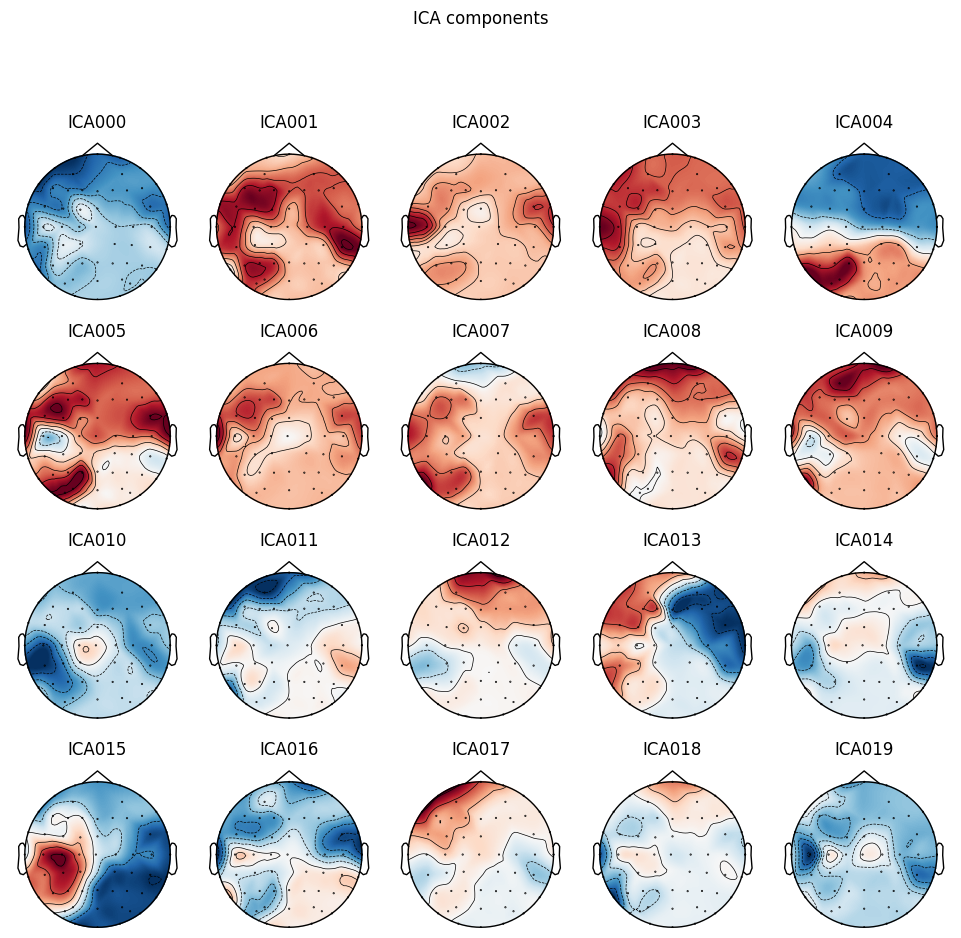

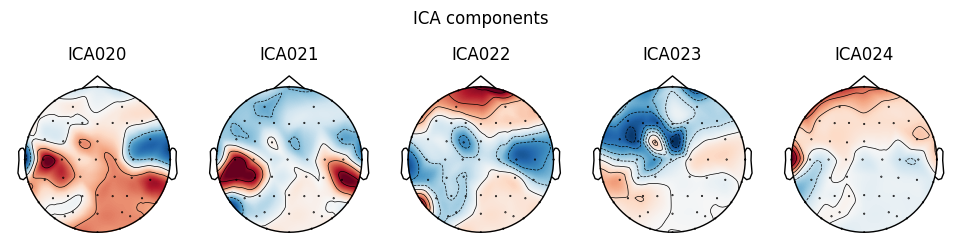

Creating RawArray with float64 data, n_channels=25, n_times=270017
    Range : 0 ... 270016 =      0.000 ...   135.008 secs
Ready.


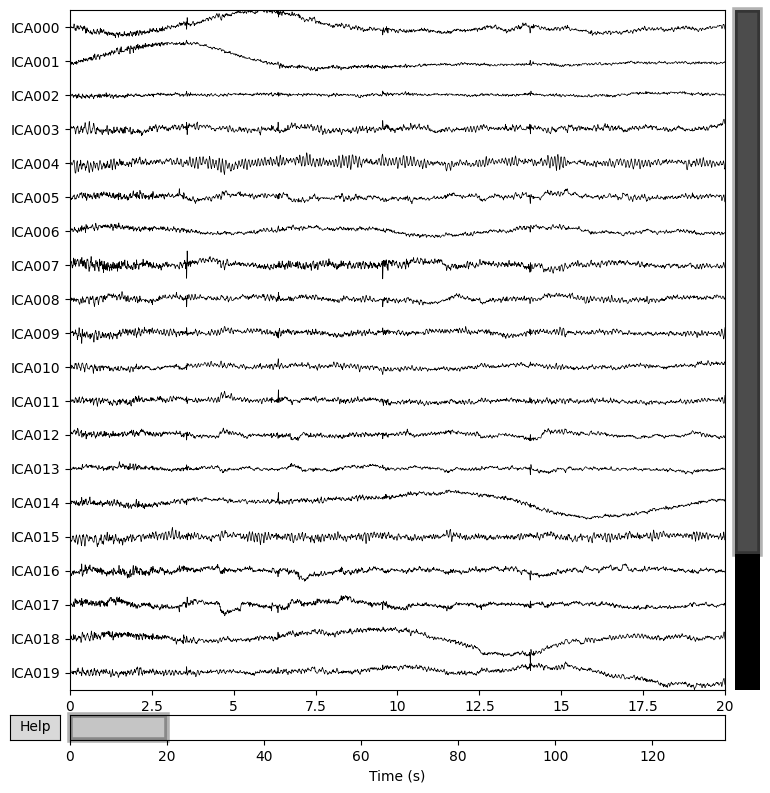

Subject S02: sub-S02_eegBaselineOE


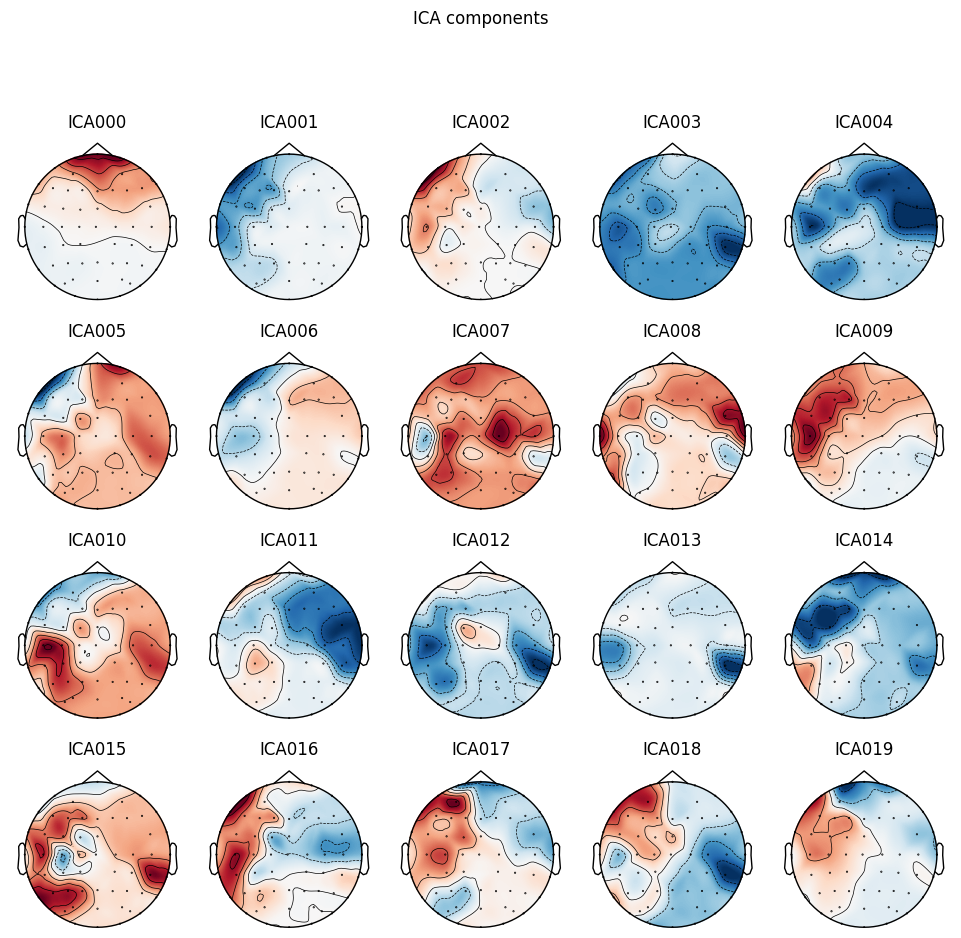

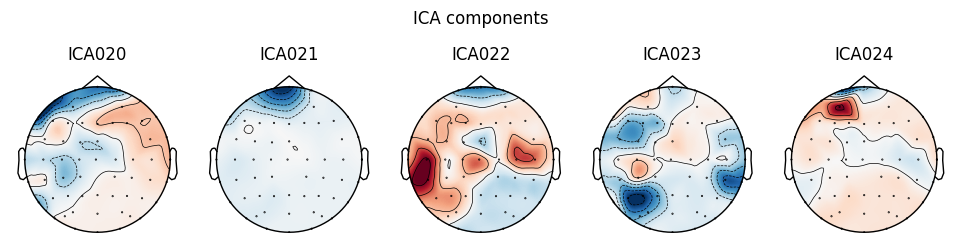

Creating RawArray with float64 data, n_channels=25, n_times=269026
    Range : 0 ... 269025 =      0.000 ...   134.512 secs
Ready.


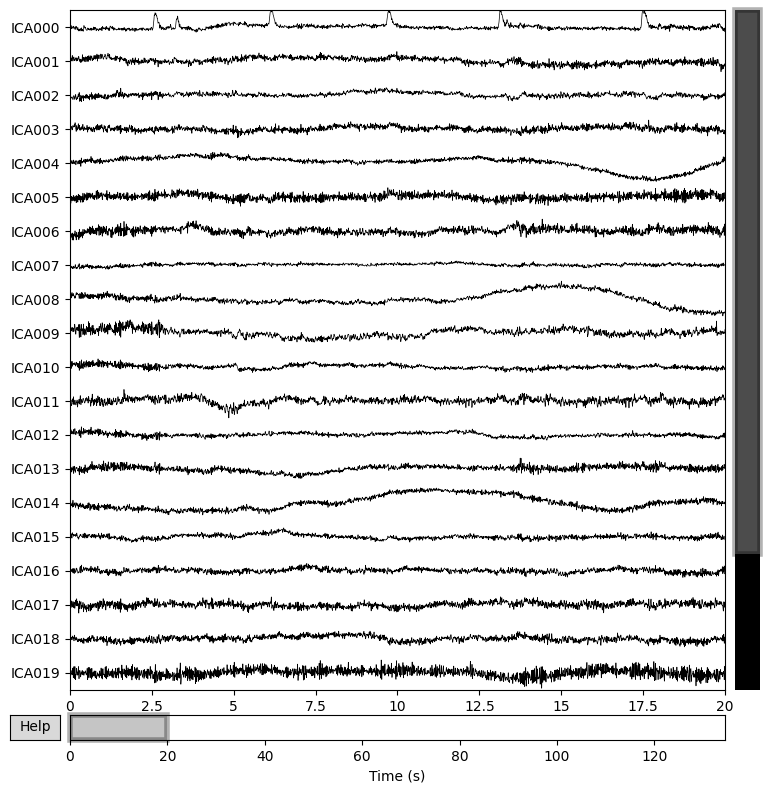

Subject S02: sub-S02_MIpost


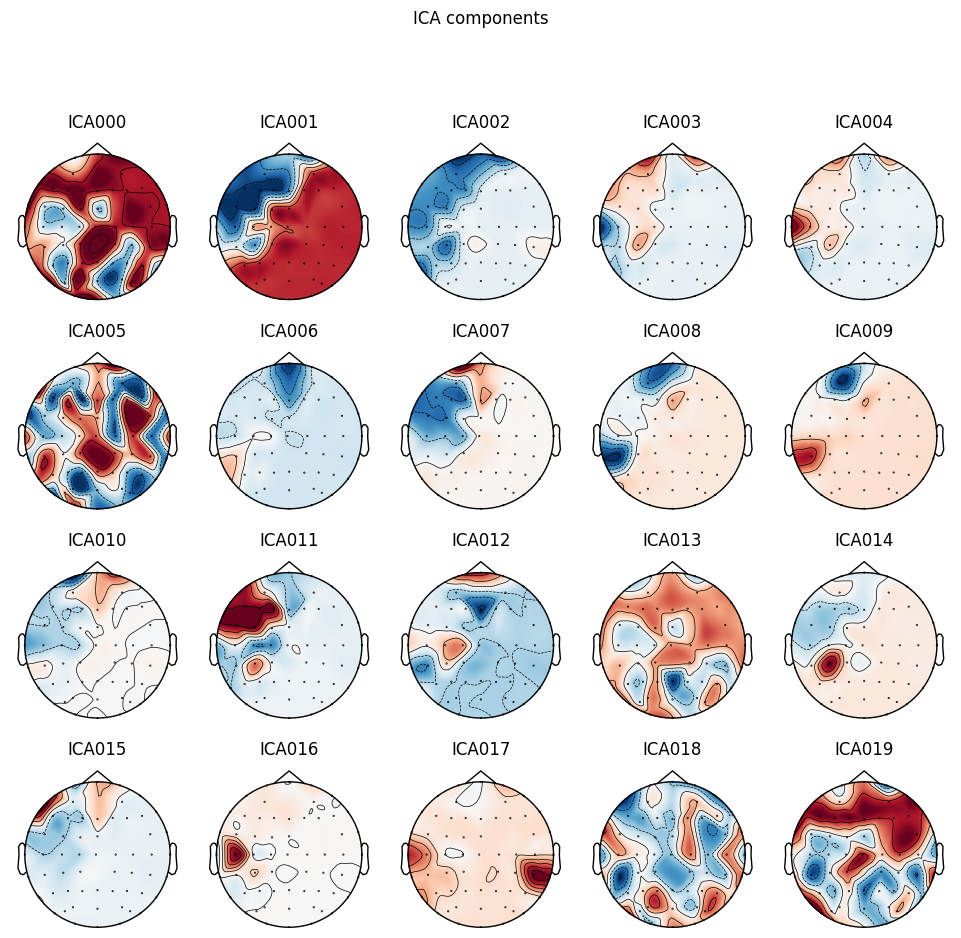

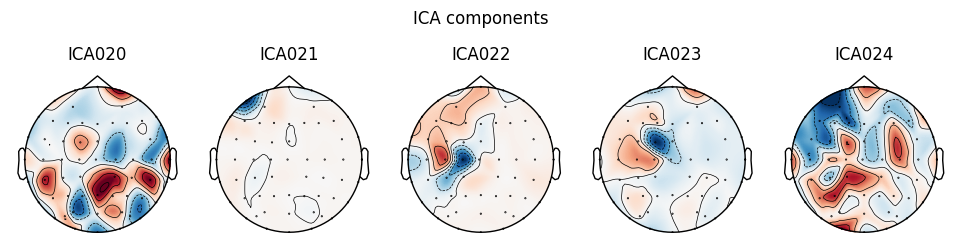

Creating RawArray with float64 data, n_channels=25, n_times=1530474
    Range : 0 ... 1530473 =      0.000 ...   765.236 secs
Ready.


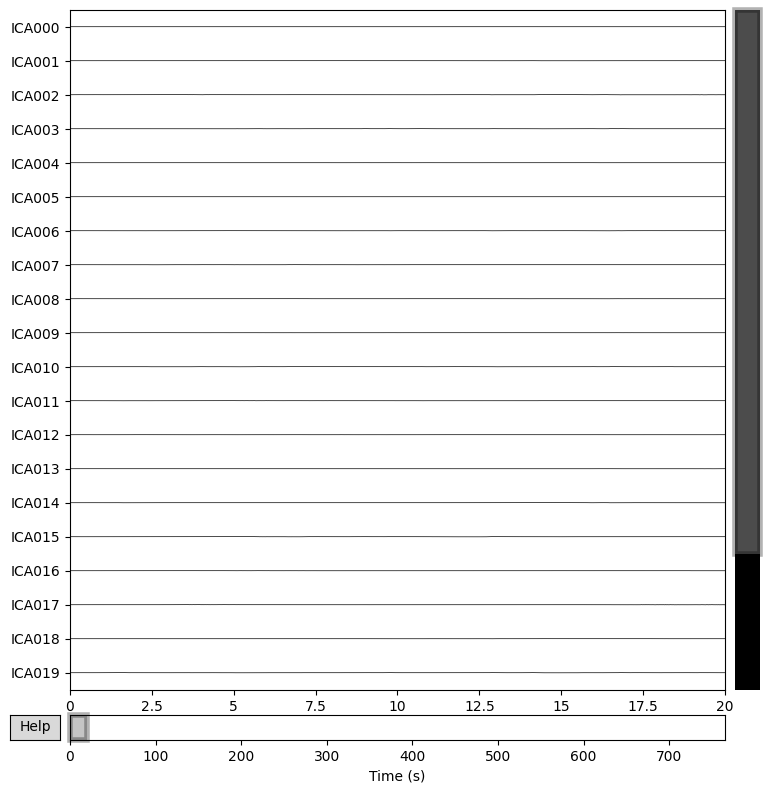

Subject S02: sub-S02_MIpre


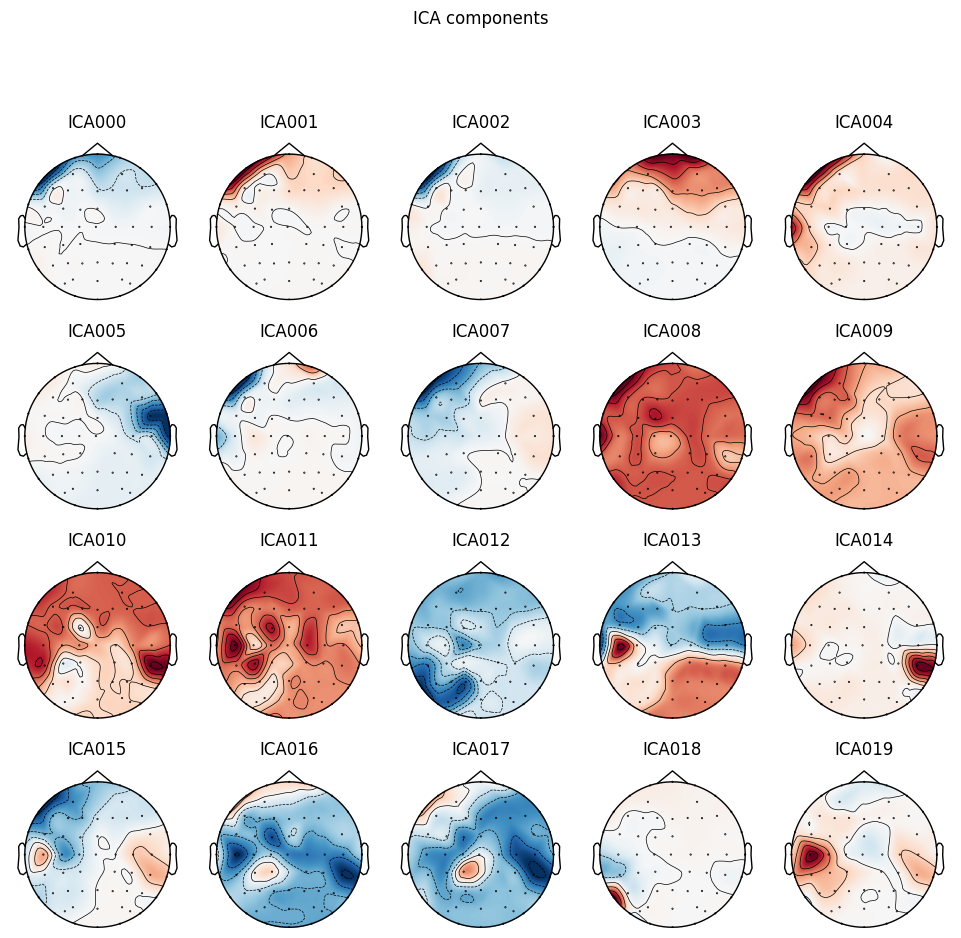

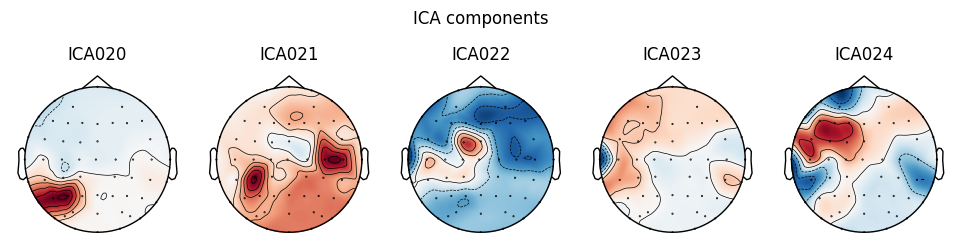

Creating RawArray with float64 data, n_channels=25, n_times=1292072
    Range : 0 ... 1292071 =      0.000 ...   646.035 secs
Ready.


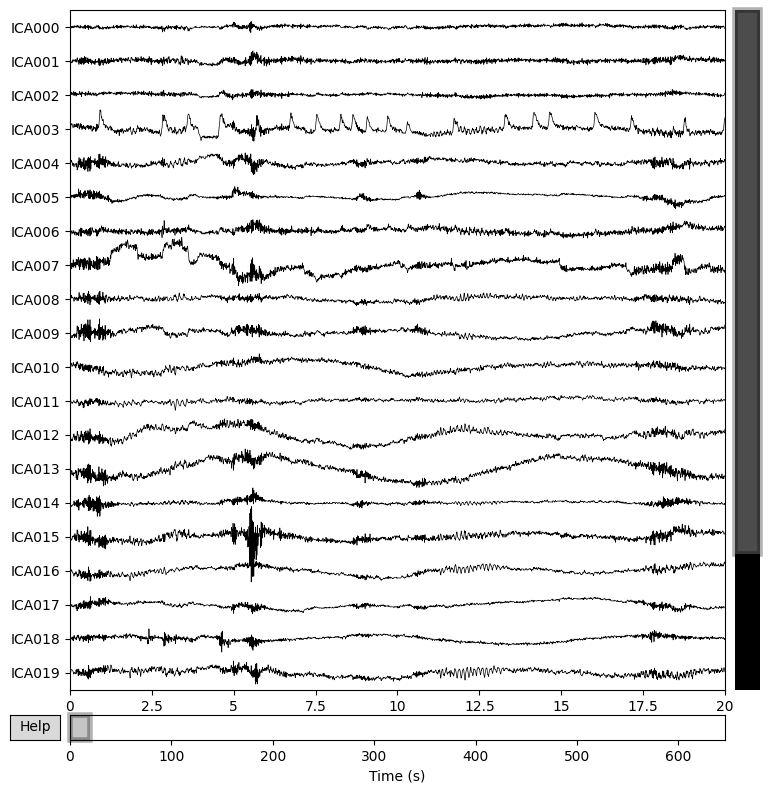

Subject S02: sub-S02_PO


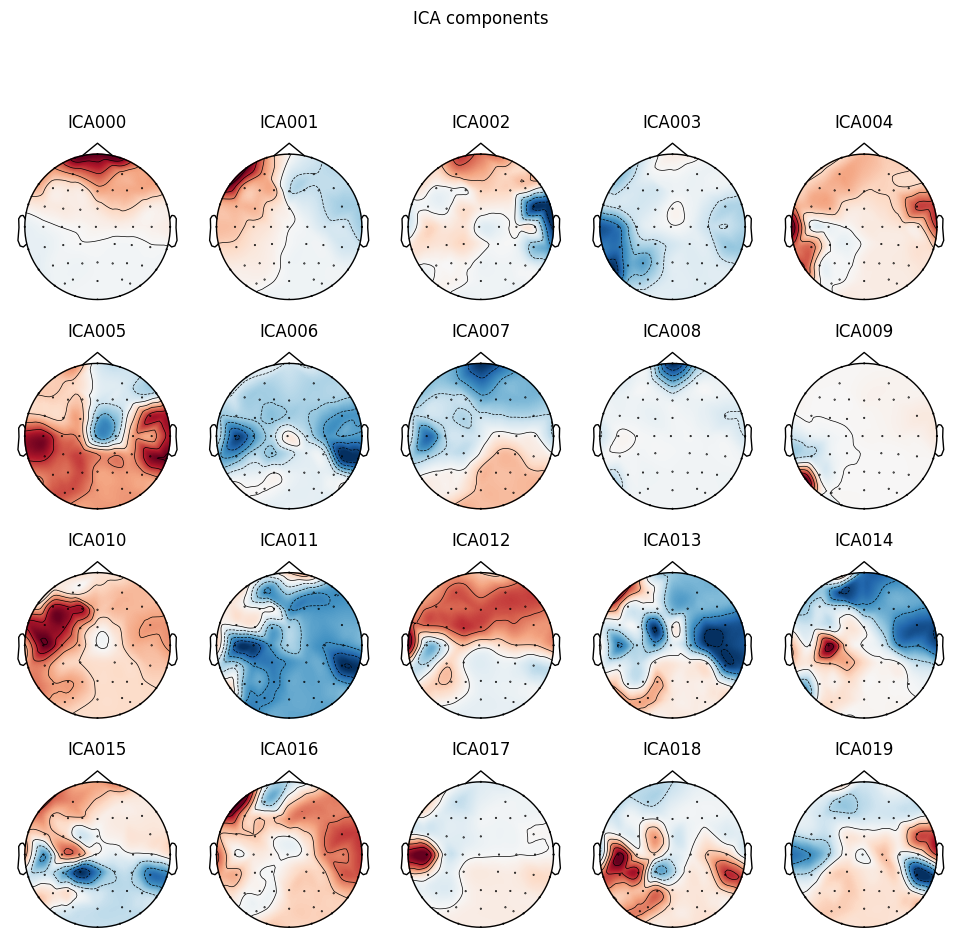

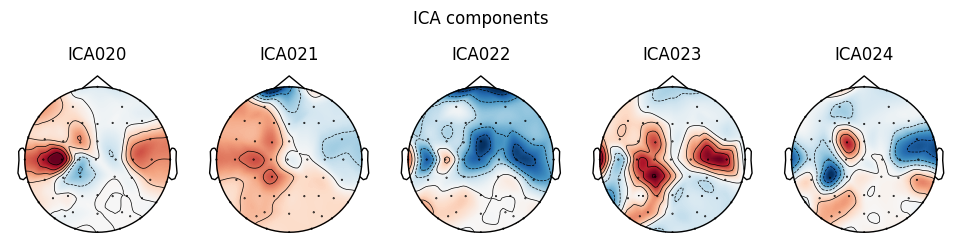

Creating RawArray with float64 data, n_channels=25, n_times=1734061
    Range : 0 ... 1734060 =      0.000 ...   867.030 secs
Ready.


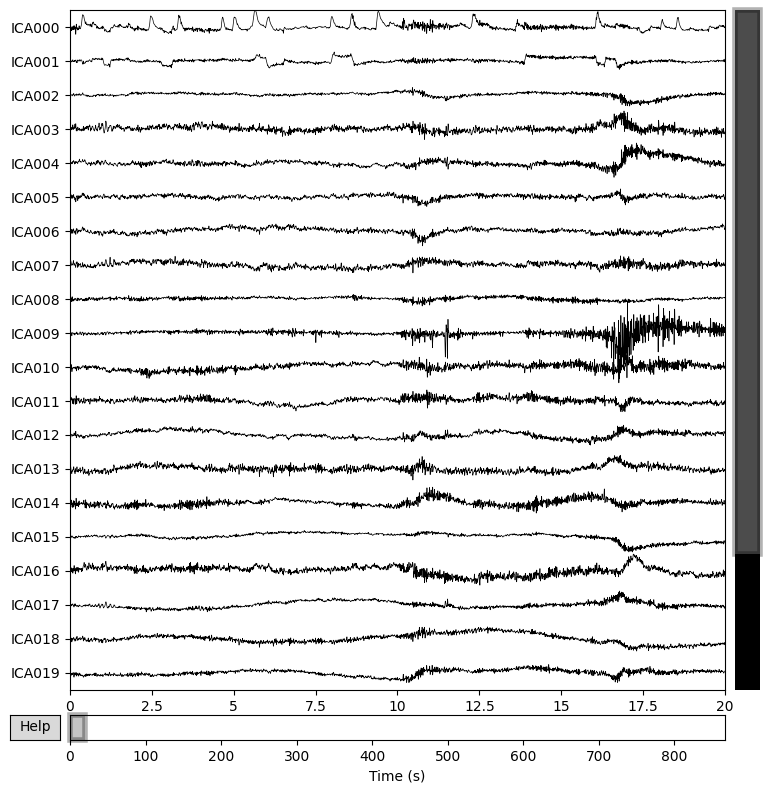

In [34]:
save_ica_imgs(ICA_dict)

### Apply ICA to correct signal

In [115]:
EEG_dict_corrected = apply_ica(EEG_dict.copy(),ICA_dict.copy())

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components


### Epoch corrected eegs

In [116]:
EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)

Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Using data from preloaded Raw for 60 events and 18001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 18001 original time points ...


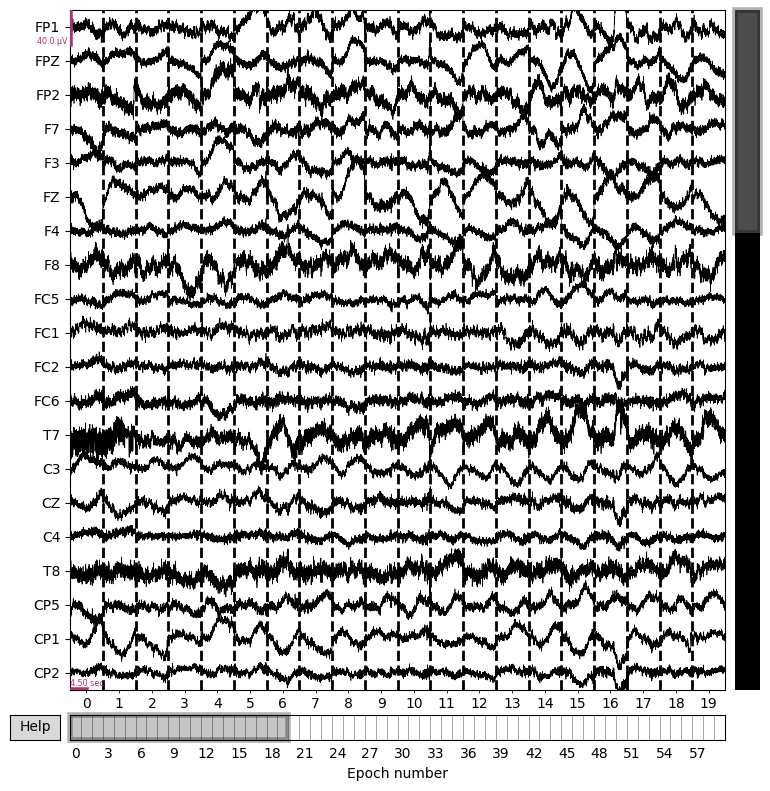

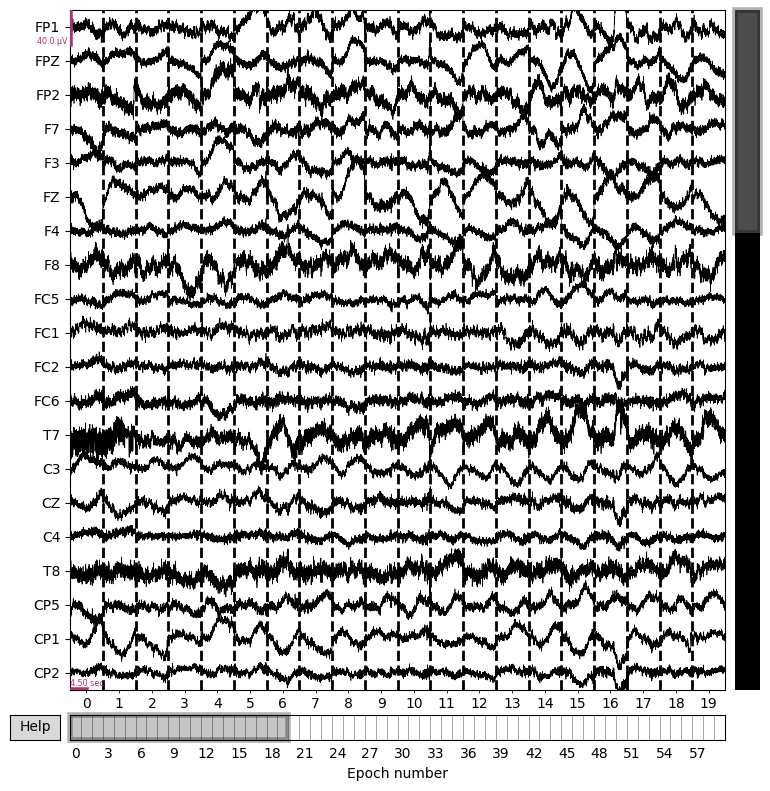

In [106]:
EEG_dict_epoched['sub-S07_MIpost_ses-S001_task-Default_run-001_eeg']['epochs'].plot()

### Saving signals

In [117]:
save_fif(EEG_dict_epoched)

Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineCE_ses-S001_task-Default_run-001_eeg-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:224: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineCE_ses-S001_task-Default_run-001_eeg-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineCE_ses-S001_task-Default_run-001_eeg-signal.fif
[done]
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineOE_ses-S001_task-Default_run-001_eeg-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:224: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineOE_ses-S001_task-Default_run-001_eeg-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_eegBaselineOE_ses-S001_task-Default_run-001_eeg-signal.fif
[done]
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpost_ses-S001_task-Default_run-001_eeg-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:224: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpost_ses-S001_task-Default_run-001_eeg-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpost_ses-S001_task-Default_run-001_eeg-signal.fif
[done]
Using data from preloaded Raw for 60 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:227: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S08/sub-S08_MIpost_ses-S001_task-Default_run-001_eeg-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


0 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 60 events and 18001 original time points ...
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpre_ses-S001_task-Default_run-001_eeg-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:224: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpre_ses-S001_task-Default_run-001_eeg-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_MIpre_ses-S001_task-Default_run-001_eeg-signal.fif
[done]
Using data from preloaded Raw for 60 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:227: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S08/sub-S08_MIpre_ses-S001_task-Default_run-001_eeg-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


0 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 60 events and 18001 original time points ...
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_PO_ses-S001_task-Default_run-001_eeg-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:224: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_PO_ses-S001_task-Default_run-001_eeg-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S08\sub-S08_PO_ses-S001_task-Default_run-001_eeg-signal.fif
[done]
Using data from preloaded Raw for 60 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_20768\3372360219.py:227: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S08/sub-S08_PO_ses-S001_task-Default_run-001_eeg-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


    Rejecting  epoch based on EEG : ['F7', 'F8', 'T7', 'T8', 'AF7', 'AF3', 'AF8', 'F5', 'F6', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'T7', 'T8', 'AF7', 'AF3', 'AF8', 'F5', 'F6', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['FPZ', 'T8', 'TP7']
3 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 57 events and 18001 original time points ...


In [ ]:
EEG_dict['sub-S02_MIpost']['signal'].save('Data/Group_Realistic_Arm/S01/test/data.fif')

### Process every subject for ICA decomposition

In [4]:
IDs = np.arange(1,21)
process_all(IDs)

Processing: Data/Group_Realistic_Arm/S01
Creating RawArray with float64 data, n_channels=64, n_times=369016
    Range : 0 ... 369015 =      0.000 ...   184.507 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.6s finished


Subject: sub-S01, EVENT: Baseline
Creating RawArray with float64 data, n_channels=64, n_times=362040
    Range : 0 ... 362039 =      0.000 ...   181.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.7s finished


Subject: sub-S01, EVENT: Baseline


Stream 1: Calculated effective sampling rate 24148.2794 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 8124.0753 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1189035
    Range : 0 ... 1189034 =      0.000 ...   594.517 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.6s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1482049
    Range : 0 ... 1482048 =      0.000 ...   741.024 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.6s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 2: Calculated effective sampling rate 495.2184 Hz is different from specified rate 999.9999 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=880085
    Range : 0 ... 880084 =      0.000 ...   440.042 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.8s finished


Subject: sub-S01, EVENT: PO
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)


Stream 5: Calculated effective sampling rate 620.8855 Hz is different from specified rate 999.9999 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=729025
    Range : 0 ... 729024 =      0.000 ...   364.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    5.5s finished


Subject: sub-S01, EVENT: PO
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
Fitting ICA to data using 60 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_8876\1125795152.py:305: RuntimeWarning: DigMontage is only a subset of info. There are 36 channel positions not present in the DigMontage. The required channels are:

['FP1', 'FPZ', 'FP2', 'FZ', 'FC5', 'FC1', 'FC2', 'FC6', 'CZ', 'CP5', 'CP1', 'CP2', 'CP6', 'PZ', 'POZ', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'FC3', 'FCZ', 'FC4', 'CP3', 'CP4', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components


KeyboardInterrupt: 

### ICA correction for all subjects

In [7]:
ica_correction(np.arange(1,21))

Processing: Data/Group_Realistic_Arm/S01
Creating RawArray with float64 data, n_channels=64, n_times=369016
    Range : 0 ... 369015 =      0.000 ...   184.507 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.2s finished


Subject: sub-S01, EVENT: Baseline
Creating RawArray with float64 data, n_channels=64, n_times=362040
    Range : 0 ... 362039 =      0.000 ...   181.019 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    4.9s finished


Subject: sub-S01, EVENT: Baseline


Stream 1: Calculated effective sampling rate 24148.2794 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 8124.0753 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1189035
    Range : 0 ... 1189034 =      0.000 ...   594.517 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    9.1s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1482049
    Range : 0 ... 1482048 =      0.000 ...   741.024 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   11.9s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 2: Calculated effective sampling rate 495.2184 Hz is different from specified rate 999.9999 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=880085
    Range : 0 ... 880084 =      0.000 ...   440.042 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    7.1s finished


Subject: sub-S01, EVENT: PO
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)


Stream 5: Calculated effective sampling rate 620.8855 Hz is different from specified rate 999.9999 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=729025
    Range : 0 ... 729024 =      0.000 ...   364.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    6.8s finished


Subject: sub-S01, EVENT: PO
Used Annotations descriptions: ['2', '5', '8']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_eegBaselineCE_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_eegBaselineOE_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpost_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpre_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_PO_Block1_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_PO_Block2_ica ...
Now restoring ICA solution ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:385: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_eegBaselineCE_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:385: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_eegBaselineOE_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:385: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpost_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz,

Ready.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel

C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_eegBaselineCE-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_eegBaselineCE-signal.fif
[done]
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_eegBaselineOE-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_eegBaselineOE-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_eegBaselineOE-signal.fif
[done]
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpost-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpost-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpost-signal.fif
[done]
Using data from preloaded Raw for 60 events and 18001 original time points ...
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'F7', 'F8', 'FC2', 'FC6', 'T7', 'C4', 'T8', 'CP6', 'AF7', 'AF8', 'F2', 'FC4', 'CP4', 'FT7', 'FT8']


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:250: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/FIF/sub-S01_MIpost-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FP2', 'F7', 'F8', 'AF7', 'AF8']
3 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 57 events and 18001 original time points ...
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpre-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpre-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_MIpre-signal.fif
[done]
Using data from preloaded Raw for 60 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:250: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/FIF/sub-S01_MIpre-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F4', 'F8', 'AF7', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'AF7']
11 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 49 events and 18001 original time points ...
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block1-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block1-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block1-signal.fif
[done]
Using data from preloaded Raw for 29 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:250: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/FIF/sub-S01_PO_Block1-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F7', 'F8', 'T7', 'T8', 'P8', 'AF7', 'AF8', 'FT7']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
3 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 26 events and 18001 original time points ...
Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block2-signal.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:247: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block2-signal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\FIF\sub-S01_PO_Block2-signal.fif
[done]
Using data from preloaded Raw for 30 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_21628\2790987980.py:250: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/FIF/sub-S01_PO_Block2-epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)


    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2', 'F7', 'F4', 'F8', 'T7', 'T8', 'CP5', 'CP1', 'CP2', 'P7', 'P3', 'P4', 'P8', 'O1', 'O2', 'AF7', 'AF8', 'F6', 'C2', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'PO7', 'PO8', 'OZ']
1 bad epochs dropped
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 29 events and 18001 original time points ...
Processing: Data/Group_Realistic_Arm/S02
Creating RawArray with float64 data, n_channels=64, n_times=270017
    Range : 0 ... 270016 =      0.000 ...   135.008 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    3.2s finished


Subject: sub-S02, EVENT: Baseline
Creating RawArray with float64 data, n_channels=64, n_times=269026
    Range : 0 ... 269025 =      0.000 ...   134.512 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.9s finished


Subject: sub-S02, EVENT: Baseline


Stream 3: Calculated effective sampling rate 4369.2772 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 12901.4323 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1530474
    Range : 0 ... 1530473 =      0.000 ...   765.236 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   11.7s finished


Subject: sub-S02, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


Stream 1: Calculated effective sampling rate 4797.1930 Hz is different from specified rate 500.0000 Hz.
Stream 3: Calculated effective sampling rate 14164.9345 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1292072
    Range : 0 ... 1292071 =      0.000 ...   646.035 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.8s finished


Subject: sub-S02, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


KeyboardInterrupt: 

### Miscellaneous

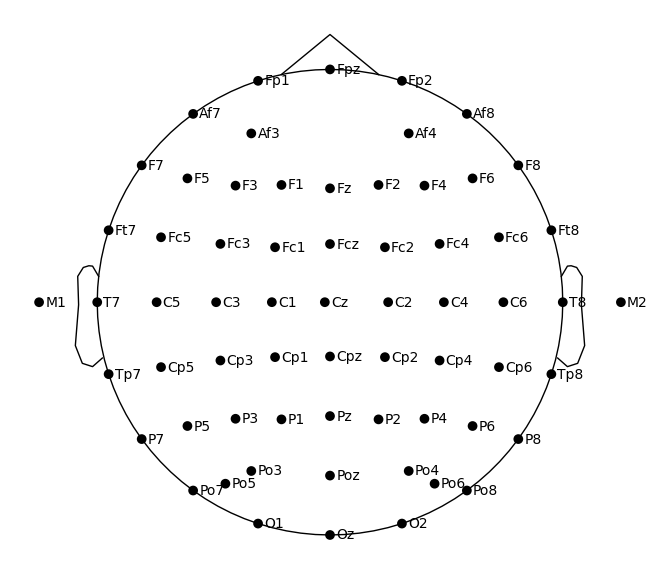

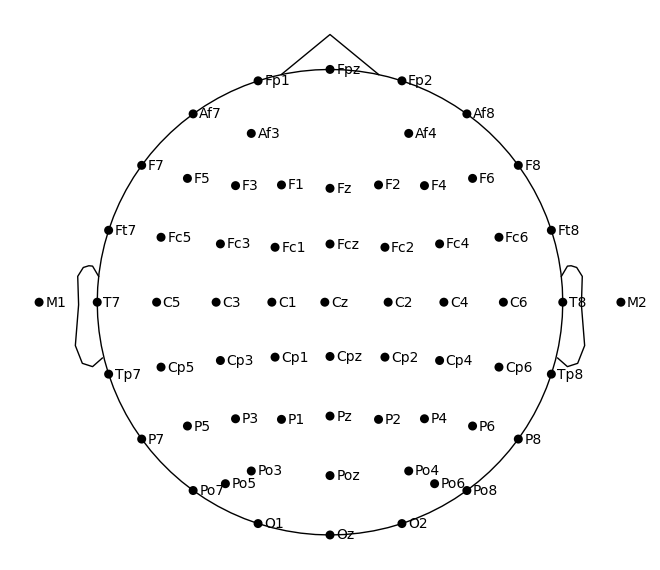

In [29]:
montage = get_montage(MONTAGE)
montage.plot()


In [12]:
import pandas as pd
df = pd.read_csv('Data\subject_recap.csv')
df.head(50)

Unnamed: 0  subject                        group experience bandpass[Hz]  \
0            0  sub-S01          Group_Realistic_Arm     MIpost       1.5-40   
1            1  sub-S01          Group_Realistic_Arm      MIpre       1.5-40   
2            2  sub-S02          Group_Realistic_Arm     MIpost       1.5-40   
3            3  sub-S02          Group_Realistic_Arm      MIpre       1.5-40   
4            4  sub-S02          Group_Realistic_Arm         PO       1.5-40   
5            5  sub-S03          Group_Realistic_Arm     MIpost       1.5-40   
6            6  sub-S03          Group_Realistic_Arm      MIpre       1.5-40   
7            7  sub-S03          Group_Realistic_Arm         PO       1.5-40   
8            8  sub-S04          Group_Realistic_Arm     MIpost       1.5-40   
9            9  sub-S04          Group_Realistic_Arm      MIpre       1.5-40   
10          10  sub-S04          Group_Realistic_Arm         PO       1.5-40   
11          11  sub-S05          Group_Realistic_Arm     MIpost       1.5-40   
12          12  sub-S05          Group_Realistic_Arm      MIpre       1.5-40   
13          13  sub-S05          Group_Realistic_Arm         PO       1.5-40   
14          14  sub-S07          Group_Realistic_Arm     MIpost       1.5-40   
15          15  sub-S07          Group_Realistic_Arm      MIpre       1.5-40   
16          16  sub-S07          Group_Realistic_Arm         PO       1.5-40   
17          17  sub-S08          Group_Realistic_Arm     MIpost       1.5-40   
18          18  sub-S08          Group_Realistic_Arm      MIpre       1.5-40   
19          19  sub-S08          Group_Realistic_Arm         PO       1.5-40   
20          20  sub-S09          Group_Realistic_Arm     MIpost       1.5-40   
21          21  sub-S09          Group_Realistic_Arm      MIpre       1.5-40   
22          22  sub-S09          Group_Realistic_Arm         PO       1.5-40   
23          23  sub-S10          Group_Realistic_Arm     MIpost       1.5-40   
24          24  sub-S10          Group_Realistic_Arm      MIpre       1.5-40   
25          25  sub-S10          Group_Realistic_Arm         PO       1.5-40   
26          26  sub-S11  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
27          27  sub-S11  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
28          28  sub-S11  Group_Realistic_Arm_Tactile         PO       1.5-40   
29          29  sub-S12  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
30          30  sub-S12  Group_Realistic_Arm_Tactile         PO       1.5-40   
31          31  sub-S13  Group_Realistic_Arm_Tactile         PO       1.5-40   
32          32  sub-S14  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
33          33  sub-S14  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
34          34  sub-S14  Group_Realistic_Arm_Tactile         PO       1.5-40   
35          35  sub-S15  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
36          36  sub-S15  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
37          37  sub-S15  Group_Realistic_Arm_Tactile         PO       1.5-40   
38          38  sub-S16  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
39          39  sub-S16  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
40          40  sub-S16  Group_Realistic_Arm_Tactile         PO       1.5-40   
41          41  sub-S17  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
42          42  sub-S17  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
43          43  sub-S17  Group_Realistic_Arm_Tactile         PO       1.5-40   
44          44  sub-S18  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
45          45  sub-S18  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
46          46  sub-S18  Group_Realistic_Arm_Tactile         PO       1.5-40   
47          47  sub-S19  Group_Realistic_Arm_Tactile     MIpost       1.5-40   
48          48  sub-S19  Group_Realistic_Arm_Tactile      MIpre       1.5-40   
49  

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

    Unnamed: 0  subject                        group experience bandpass[Hz]  \
0            0  sub-S01          Group_Realistic_Arm     MIpost       1.5-40   
1            1  sub-S01          Group_Realistic_Arm      MIpre       1.5-40   
2            2  sub-S02          Group_Realistic_Arm     MIpost       1.5-40   
3            3  sub-S02          Group_Realistic_Arm      MIpre       1.5-40   
4            4  sub-S02          Group_Realistic_Arm         PO       1.5-40   
5            5  sub-S03          Group_Realistic_Arm     MIpost       1.5-40   
6            6  sub-S03          Group_Realistic_Arm      MIpre       1.5-40   
7            7  sub-S03          Group_Realistic_Arm         PO       1.5-40   
8            8  sub-S04          Group_Realistic_Arm     MIpost       1.5-40   
9            9  sub-S04          Group_Realistic_Arm      MIpre       1.5-40   
10          10  sub-S04          Group_Realistic_Arm         PO       1.5-40   
11          11  sub-S05          Group_R

In [ ]:
data,header = pyxdf.load_xdf('Data\S01\sub-S01_MIpre.xdf')

In [ ]:
data[2]['info']['desc'][0]['channels'][0]['channel'][0]['label'][0]